In [ ]:
# Install the Kaggle library
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

In [ ]:
# Make the directory for the Kaggle configuration file
!mkdir -p ~/.kaggle

# Move the uploaded kaggle.json to the .kaggle directory
!mv kaggle.json ~/.kaggle/

# Set file permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d vibhingupta028/liver-histopathology-fibrosis-ultrasound-images

# Unzip the dataset
!unzip liver-histopathology-fibrosis-ultrasound-images.zip -d ./liver_dataset

## Data Preparation

Total images: 6323
Training set: 5058 images
Test set: 1265 images


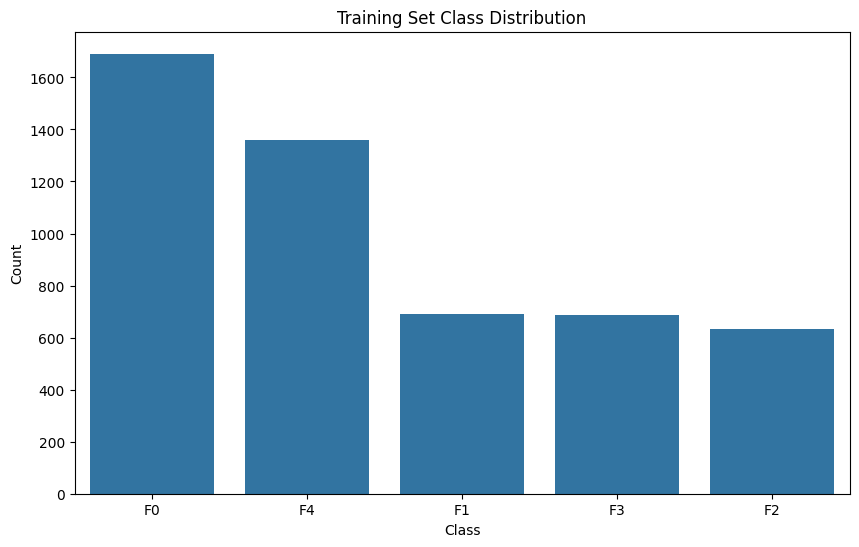

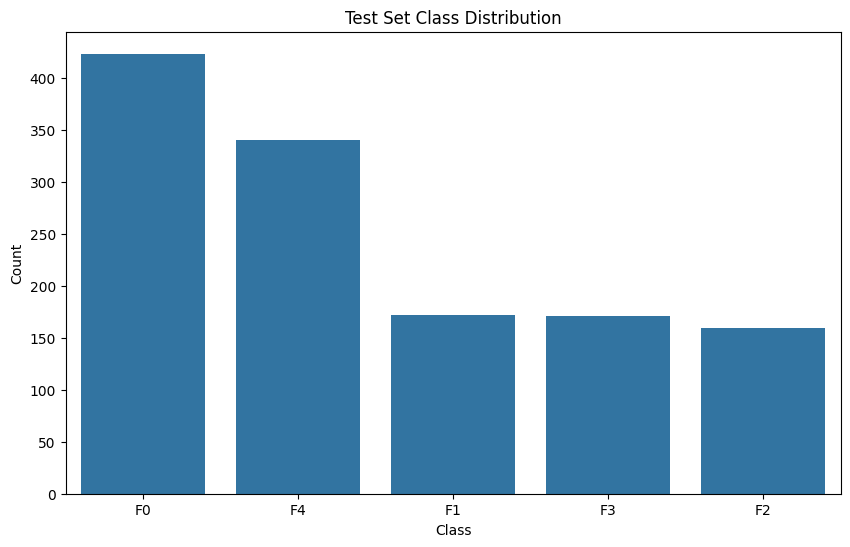

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the path to the dataset
image_folder = './liver_dataset/Dataset/Dataset/'

# List class directories
class_labels = ['F0', 'F1', 'F2', 'F3', 'F4']

# Collect image file paths and their labels
image_paths = []
labels = []

for label in class_labels:
    class_folder = os.path.join(image_folder, label)
    for img_name in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, img_name))
        labels.append(label)

# Create a DataFrame for easier handling
data = pd.DataFrame({'Image_Path': image_paths, 'Label': labels})

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['Label'], random_state=42)

# Verify the split
print(f"Total images: {len(data)}")
print(f"Training set: {len(train_data)} images")
print(f"Test set: {len(test_data)} images")

# Plot the class distribution for training and test sets
def plot_class_distribution(data, title):
    class_counts = data['Label'].value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Count', data=class_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(train_data, "Training Set Class Distribution")
plot_class_distribution(test_data, "Test Set Class Distribution")

In [ ]:
train_data

,Image_Path,Label
4676,./liver_dataset/Dataset/Dataset/F4/g7.jpg,F4
5258,./liver_dataset/Dataset/Dataset/F4/d24.jpg,F4
661,./liver_dataset/Dataset/Dataset/F0/a7713.jpg,F0
932,./liver_dataset/Dataset/Dataset/F0/j26.jpg,F0
759,./liver_dataset/Dataset/Dataset/F0/a290.jpg,F0
...,...,...
2638,./liver_dataset/Dataset/Dataset/F1/B8932.jpg,F1
3339,./liver_dataset/Dataset/Dataset/F2/u6038.jpg,F2
799,./liver_dataset/Dataset/Dataset/F0/a2710.jpg,F0
2353,./liver_dataset/Dataset/Dataset/F1/h2767.jpg,F1


In [ ]:
from PIL import Image
import numpy as np

# Path to the image
image_path = "./liver_dataset/Dataset/Dataset/F1/h2767.jpg"

# Open the image
image = Image.open(image_path)

# Convert the image to a NumPy array
image_array = np.array(image)

# Get dimensions
height, width = image_array.shape[:2]  # First two values are height and width
channels = 1 if len(image_array.shape) == 2 else image_array.shape[2]  # Check if grayscale (no third dimension)

print(f"Image dimensions: {width}x{height}")
print(f"Number of channels: {channels}")

Image dimensions: 640x480
Number of channels: 1


## Training with no augmentation

In [ ]:
from PIL import Image
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical

In [ ]:
import os
import numpy as np
from PIL import Image

# Updated function to load images and labels based on DataFrame input
def load_images_and_labels_from_dataframe(dataframe, image_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(dataframe['Label'].unique())
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for _, row in dataframe.iterrows():
        img_path = row['Image_Path']
        label = row['Label']
        img = Image.open(img_path)

        # Check if image is in grayscale and convert to RGB if necessary
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = img.resize(image_size)
        img_array = np.array(img)

        # Append the image and its corresponding label
        images.append(img_array)
        labels.append(class_indices[label])

    return np.array(images), np.array(labels), class_indices

# Load training and validation images and labels
image_size = (224, 224)  # Resize all images to 224x224 for consistency with VGG16
X_train, y_train, class_indices = load_images_and_labels_from_dataframe(train_data, image_size=image_size)
X_val, y_val, _ = load_images_and_labels_from_dataframe(test_data, image_size=image_size)

# Normalize images to [0, 1] by dividing by 255
#X_train = X_train.astype('float32') / 255.0
#X_val = X_val.astype('float32') / 255.0

# Print the number of classes and their indices
num_classes = len(class_indices)
print(f"Classes: {class_indices}")
print(f"Number of classes: {num_classes}")


Classes: {'F0': 0, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4}
Number of classes: 5


In [ ]:
X_train.shape
y_train.shape

(5058,)

## testing my own model

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Dropout

model = Sequential([
    Conv2D(40, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(40, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(40, kernel_size=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Conv2D(70, kernel_size=(2, 2), activation='relu'),
    Conv2D(70, kernel_size=(3, 3), activation='relu'),
    Conv2D(70, kernel_size=(4, 4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 223, 223, 40)        │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 221, 221, 40)        │          14,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 218, 218, 40)        │          25,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 109, 109, 40)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 109, 109, 40)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 108, 108, 70)        │          11,270 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 106, 106, 70)        │          44,170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 103, 103, 70)        │          78,470 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 51, 51, 70)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 51, 51, 70)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 182070)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      46,610,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,785,971 (178.47 MB)

 Trainable params: 46,785,971 (178.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                           epochs=200,
                           batch_size=5,
                           validation_data=(X_val, y_val),
                           callbacks=[early_stopping])

Epoch 1/200
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 89s 73ms/step - accuracy: 0.5378 - loss: 4.5578 - val_accuracy: 0.7304 - val_loss: 0.7081
Epoch 2/200
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 115s 59ms/step - accuracy: 0.7260 - loss: 0.6769 - val_accuracy: 0.8617 - val_loss: 0.4080
Epoch 3/200
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.8390 - loss: 0.4058 - val_accuracy: 0.8830 - val_loss: 0.2921
Epoch 4/200
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.9159 - loss: 0.2322 - val_accuracy: 0.9557 - val_loss: 0.1686
Epoch 5/200
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.9466 - loss: 0.1592 - val_accuracy: 0.9628 - val_loss: 0.1456
Epoch 6/200
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 84s 59ms/step - accuracy: 0.9670 - loss: 0.1046 - val_accuracy: 0.9557 - val_loss: 0.1605
Epoch 7/200
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.9698 - loss: 0.1093 - val_accuracy: 0.9755 - val_loss: 0.1130
Epoch 8/200
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy:

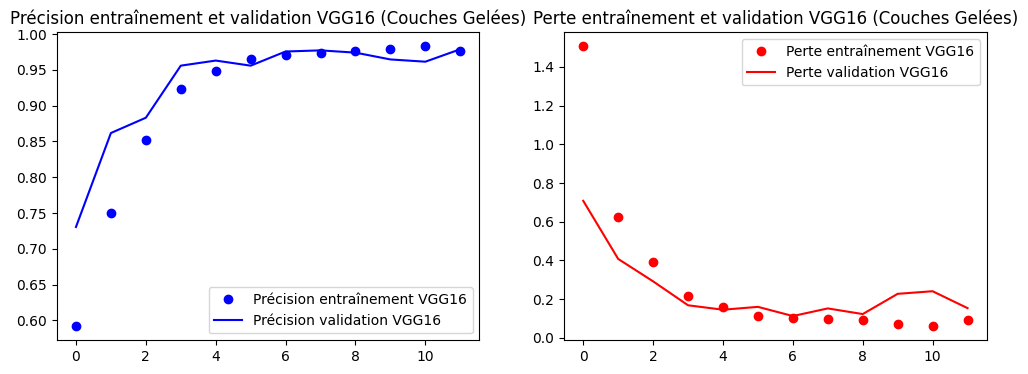

In [ ]:
acc_vgg = history.history['accuracy']
val_acc_vgg = history.history['val_accuracy']
loss_vgg = history.history['loss']
val_loss_vgg = history.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_vgg, 'bo', label='Précision entraînement VGG16')
plt.plot(epochs, val_acc_vgg, 'b', label='Précision validation VGG16')
plt.title('Précision entraînement et validation VGG16 (Couches Gelées)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vgg, 'ro', label='Perte entraînement VGG16')
plt.plot(epochs, val_loss_vgg, 'r', label='Perte validation VGG16')
plt.title('Perte entraînement et validation VGG16 (Couches Gelées)')
plt.legend()

plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


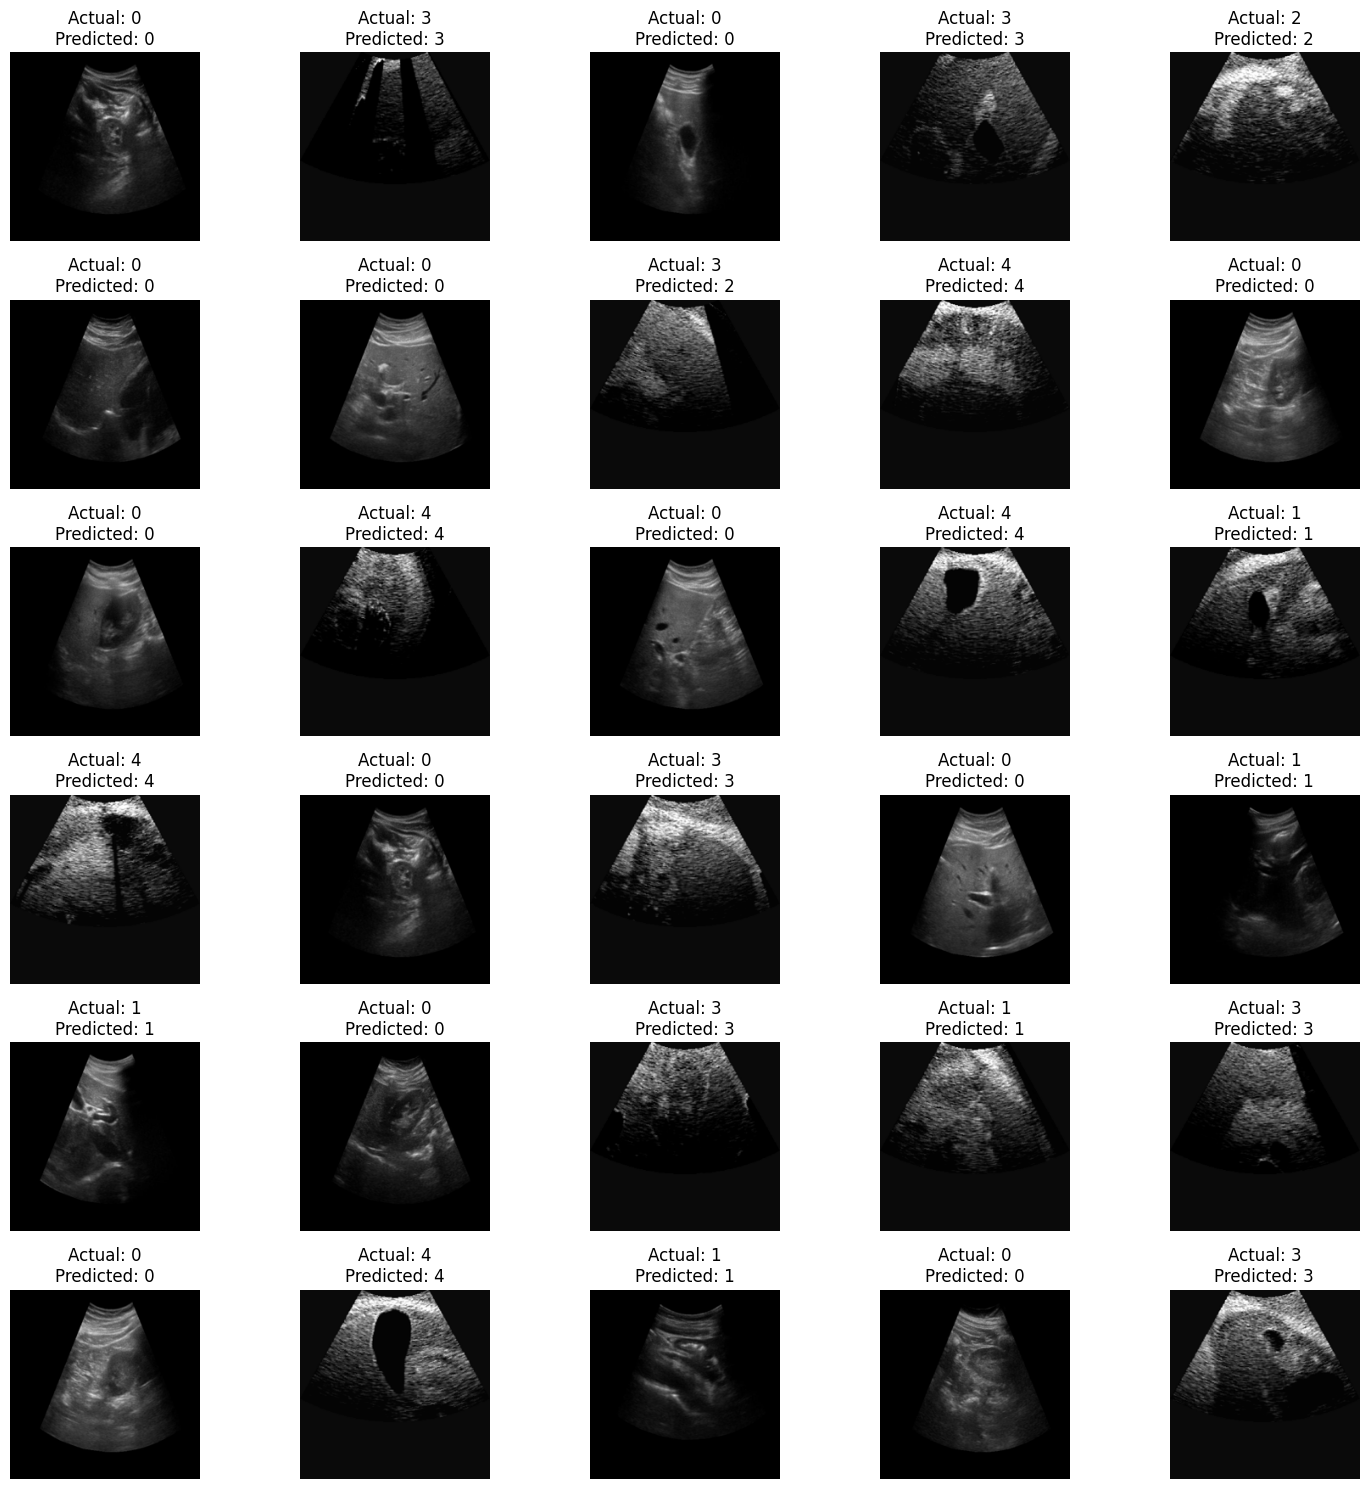

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Get the predicted class labels (for sparse categorical crossentropy, we use argmax)
y_pred_labels = np.argmax(y_pred, axis=1)

# Randomly select 30 images and their corresponding labels
num_images = 30
random_indices = np.random.choice(X_val.shape[0], num_images, replace=False)

# Set up the plot
plt.figure(figsize=(15, 15))

# Loop over the selected random indices to plot the images
for i, idx in enumerate(random_indices):
    plt.subplot(6, 5, i+1)  # 6 rows, 5 columns
    img = X_val[idx].squeeze()  # Remove the channel dimension if it's there
    actual_label = y_val[idx]
    predicted_label = y_pred_labels[idx]

    # Plot the image
    plt.imshow(img, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Turn off axes

    # Set the title with the actual and predicted labels
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

## VGG 16 with Fine tuning

In [ ]:
conv_base_vgg = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

In [ ]:
# Congeler toutes les couches du modèle pré-entraîné
conv_base_vgg.trainable = False

# Décongeler les dernières couches pour le fine-tuning
for layer in conv_base_vgg.layers[-4:]:
    layer.trainable = True

print("Couches entraînables dans VGG16:")
for layer in conv_base_vgg.layers:
    print(f"{layer.name}: {'Entraînable' if layer.trainable else 'Non entraînable'}")

Couches entraînables dans VGG16:
input_layer_5: Non entraînable
block1_conv1: Non entraînable
block1_conv2: Non entraînable
block1_pool: Non entraînable
block2_conv1: Non entraînable
block2_conv2: Non entraînable
block2_pool: Non entraînable
block3_conv1: Non entraînable
block3_conv2: Non entraînable
block3_conv3: Non entraînable
block3_pool: Non entraînable
block4_conv1: Non entraînable
block4_conv2: Non entraînable
block4_conv3: Non entraînable
block4_pool: Non entraînable
block5_conv1: Entraînable
block5_conv2: Entraînable
block5_conv3: Entraînable
block5_pool: Entraînable


In [ ]:
model_vgg = models.Sequential()
model_vgg.add(conv_base_vgg)  # Add VGG16 as the base
model_vgg.add(layers.Flatten())  # Flatten the output of the convolutional base
model_vgg.add(layers.Dense(128, activation='relu'))  # Dense layer with ReLU
model_vgg.add(layers.Dropout(0.3))  # Dropout layer for regularization
model_vgg.add(layers.Dense(5, activation='softmax'))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=4,              # Stop after 4 epochs with no improvement
    restore_best_weights=True  # Restore weights of the best model
)

# Compile the model with RMSprop optimizer
model_vgg.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),  # Small learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',  # Use binary cross-entropy for binary classification
    metrics=['accuracy']  # Track accuracy during training
)

# Print the model summary to verify the architecture
model_vgg.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,725 (68.39 MB)

 Trainable params: 10,291,461 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Entraînement avec EarlyStopping
history_vgg = model_vgg.fit(
    X_train, y_train,
    epochs=50,
    batch_size=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Ajouter le callback
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.3865 - loss: 4.0486 - val_accuracy: 0.6656 - val_loss: 0.8533
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6638 - loss: 0.9494 - val_accuracy: 0.7842 - val_loss: 0.5394
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7900 - loss: 0.5505 - val_accuracy: 0.8664 - val_loss: 0.3802
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8685 - loss: 0.3646 - val_accuracy: 0.9304 - val_loss: 0.2519
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9183 - loss: 0.2430 - val_accuracy: 0.9447 - val_loss: 0.1994
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9459 - loss: 0.1742 - val_accuracy: 0.9510 - val_loss: 0.1622
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9615 - loss: 0.1260 - val_accuracy: 0.9700 - val_loss: 0.1171
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9717 - loss: 0.1029 - val_accuracy: 0.9644 - val_loss

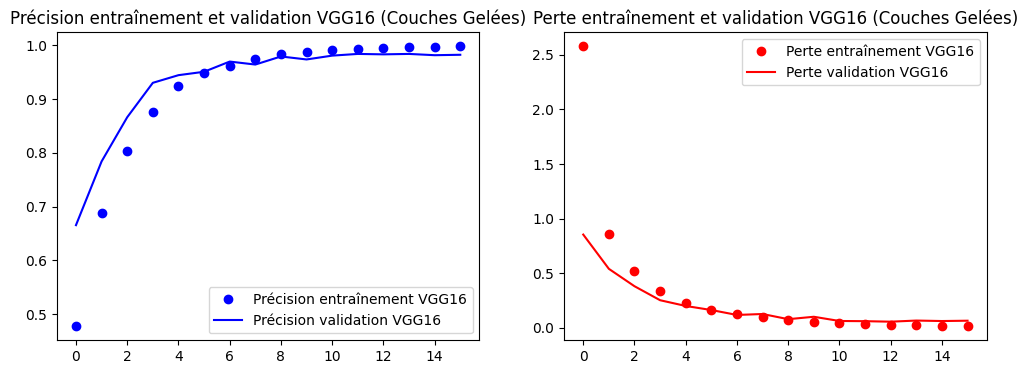

In [ ]:
acc_vgg = history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']
loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_vgg, 'bo', label='Précision entraînement VGG16')
plt.plot(epochs, val_acc_vgg, 'b', label='Précision validation VGG16')
plt.title('Précision entraînement et validation VGG16 (Couches Gelées)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vgg, 'ro', label='Perte entraînement VGG16')
plt.plot(epochs, val_loss_vgg, 'r', label='Perte validation VGG16')
plt.title('Perte entraînement et validation VGG16 (Couches Gelées)')
plt.legend()

plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 378ms/step


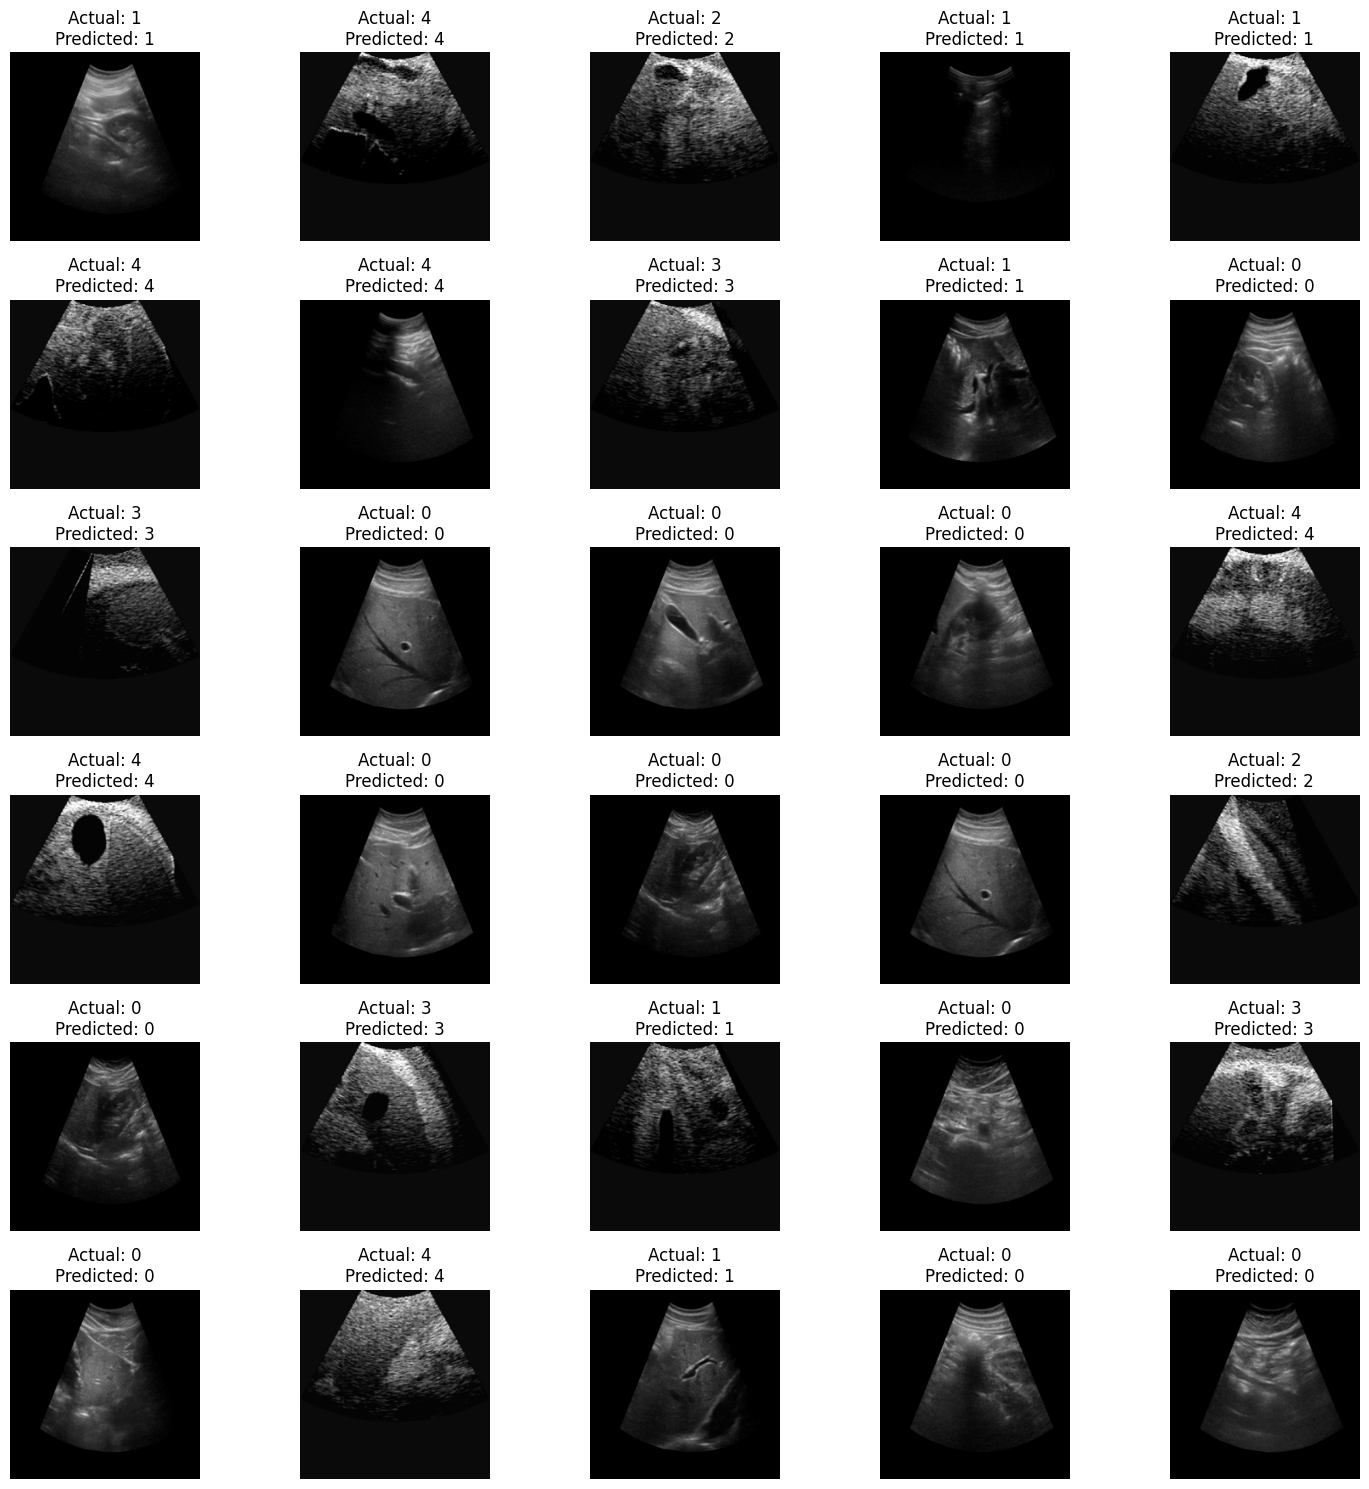

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the validation set
y_pred = model_vgg.predict(X_val)

# Get the predicted class labels (for sparse categorical crossentropy, we use argmax)
y_pred_labels = np.argmax(y_pred, axis=1)

# Randomly select 30 images and their corresponding labels
num_images = 30
random_indices = np.random.choice(X_val.shape[0], num_images, replace=False)

# Set up the plot
plt.figure(figsize=(15, 15))

# Loop over the selected random indices to plot the images
for i, idx in enumerate(random_indices):
    plt.subplot(6, 5, i+1)  # 6 rows, 5 columns
    img = X_val[idx].squeeze()  # Remove the channel dimension if it's there
    actual_label = y_val[idx]
    predicted_label = y_pred_labels[idx]

    # Plot the image
    plt.imshow(img, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Turn off axes

    # Set the title with the actual and predicted labels
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step


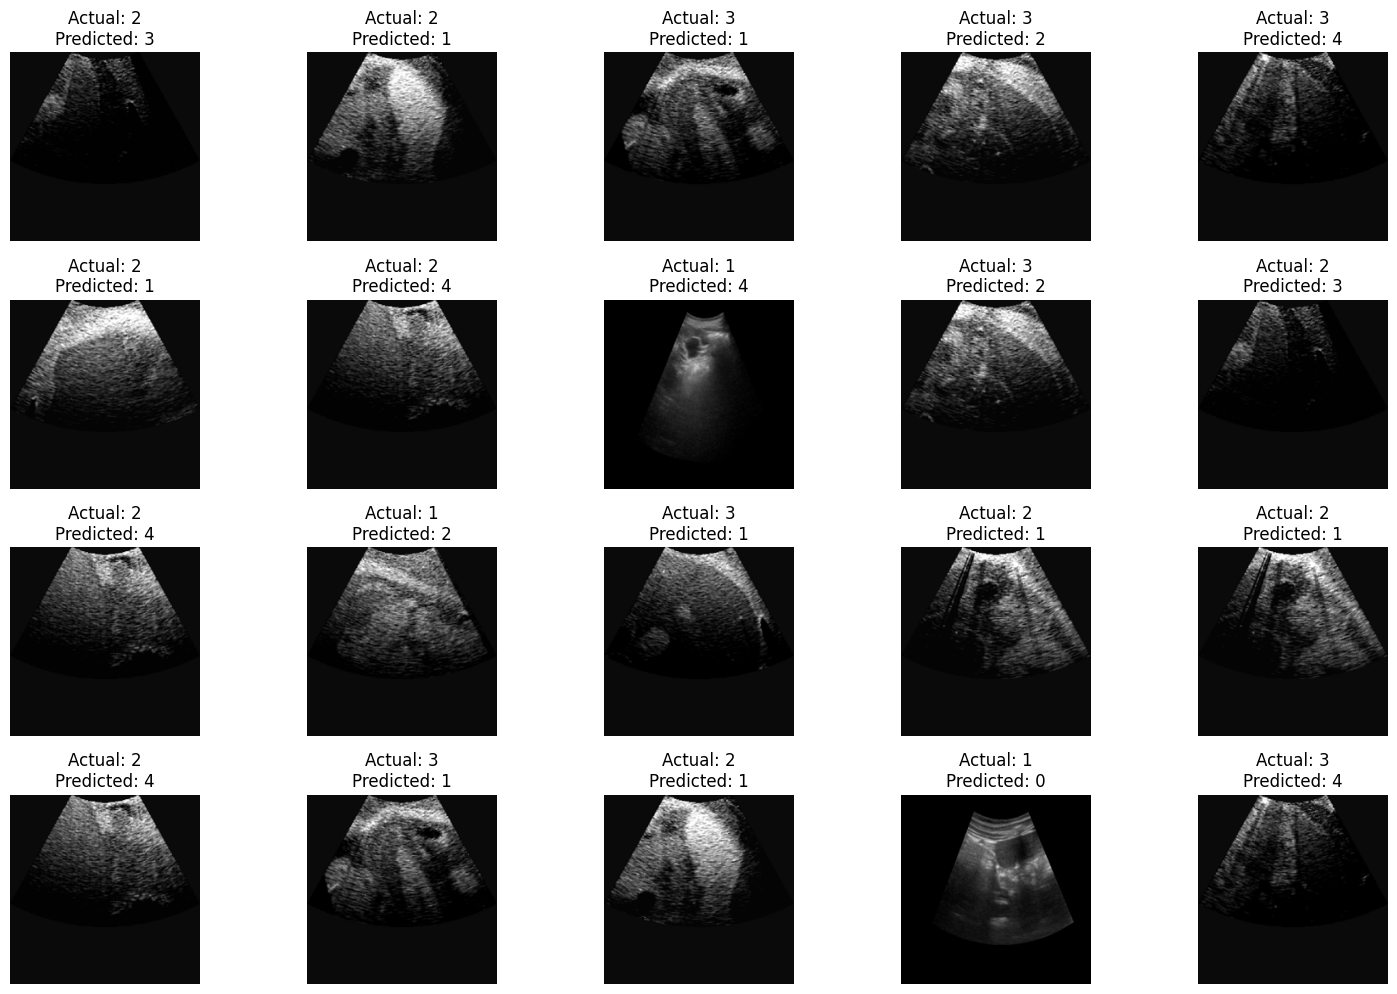

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the validation set
y_pred = model_vgg.predict(X_val)

# Get the predicted class labels (for sparse categorical crossentropy, we use argmax)
y_pred_labels = np.argmax(y_pred, axis=1)

# Identify the indices of incorrectly predicted images
incorrect_indices = np.where(y_pred_labels != y_val)[0]

# Set the number of images to display
num_images = min(30, len(incorrect_indices))  # Display up to 30 false predictions

# Randomly select from the incorrect predictions if there are more than 30
if len(incorrect_indices) > num_images:
    incorrect_indices = np.random.choice(incorrect_indices, num_images, replace=False)

# Set up the plot
plt.figure(figsize=(15, 15))

# Loop over the selected incorrect indices to plot the images
for i, idx in enumerate(incorrect_indices):
    plt.subplot(6, 5, i+1)  # 6 rows, 5 columns
    img = X_val[idx].squeeze()  # Remove the channel dimension if it's there
    actual_label = y_val[idx]
    predicted_label = y_pred_labels[idx]

    # Plot the image
    plt.imshow(img, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Turn off axes

    # Set the title with the actual and predicted labels
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()


## Resnet 50 with Fine tuning

In [ ]:
conv_base_resnet = ResNet50(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Congeler toutes les couches
conv_base_resnet.trainable = False

# Décongeler certaines couches
for layer in conv_base_resnet.layers[-20:]:
    layer.trainable = True

print("Couches entraînables dans ResNet50:")
for layer in conv_base_resnet.layers:
    print(f"{layer.name}: {'Entraînable' if layer.trainable else ''}")


Couches entraînables dans ResNet50:
input_layer_7: 
conv1_pad: 
conv1_conv: 
conv1_bn: 
conv1_relu: 
pool1_pad: 
pool1_pool: 
conv2_block1_1_conv: 
conv2_block1_1_bn: 
conv2_block1_1_relu: 
conv2_block1_2_conv: 
conv2_block1_2_bn: 
conv2_block1_2_relu: 
conv2_block1_0_conv: 
conv2_block1_3_conv: 
conv2_block1_0_bn: 
conv2_block1_3_bn: 
conv2_block1_add: 
conv2_block1_out: 
conv2_block2_1_conv: 
conv2_block2_1_bn: 
conv2_block2_1_relu: 
conv2_block2_2_conv: 
conv2_block2_2_bn: 
conv2_block2_2_relu: 
conv2_block2_3_conv: 
conv2_block2_3_bn: 
conv2_block2_add: 
conv2_block2_out: 
conv2_block3_1_conv: 
conv2_block3_1_bn: 
conv2_block3_1_relu: 
conv2_block3_2_conv: 
conv2_block3_2_bn: 
conv2_block3_2_relu: 
conv2_block3_3_conv: 
conv2_block3_3_bn: 
conv2_block3_add: 
conv2_block3_out: 
conv3_block1_1_conv: 
conv3_block1_1_bn: 
conv3_block1_1_relu: 
conv3_block1_2_conv: 
conv3_block1_2_bn: 
conv3_block1_2_relu: 
conv3_block1_0_conv: 
conv3_block1_3_conv: 
conv3_block1_0_bn: 
conv3_block1_3_b

In [ ]:
model_resnet = models.Sequential()
model_resnet.add(conv_base_resnet)
model_resnet.add(layers.GlobalAveragePooling2D())
model_resnet.add(layers.Dense(512, activation='relu'))
model_resnet.add(layers.Dropout(0.3))
model_resnet.add(layers.Dense(5, activation='sigmoid'))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=4,              # Stop after 4 epochs with no improvement
    restore_best_weights=True  # Restore weights of the best model
)

# Compile the model with RMSprop optimizer
model_resnet.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),  # Small learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',  # Use binary cross-entropy for binary classification
    metrics=['accuracy']  # Track accuracy during training
)

# Print the model summary to verify the architecture
model_resnet.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 9,982,981 (38.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [ ]:
# Entraînement avec EarlyStopping
history_resnet = model_resnet.fit(
    X_train, y_train,
    epochs=50,
    batch_size=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Ajouter le callback
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3857 - loss: 1.6576 - val_accuracy: 0.4854 - val_loss: 1.1677
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 736ms/step - accuracy: 0.6104 - loss: 0.9706 - val_accuracy: 0.5344 - val_loss: 1.0033
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 655ms/step - accuracy: 0.7135 - loss: 0.7461 - val_accuracy: 0.6348 - val_loss: 0.8717
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 727ms/step - accuracy: 0.7669 - loss: 0.6055 - val_accuracy: 0.7273 - val_loss: 0.6775
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 725ms/step - accuracy: 0.8173 - loss: 0.4978 - val_accuracy: 0.7502 - val_loss: 0.6016
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 729ms/step - accuracy: 0.8664 - loss: 0.4045 - val_accuracy: 0.7542 - val_loss: 0.5519
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 643ms/step - accuracy: 0.9072 - loss: 0.3215 - val_accuracy: 0.8411 - val_loss: 0.4139
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 727ms/step - accuracy: 0.9268 - loss: 0.2768 - val_accurac

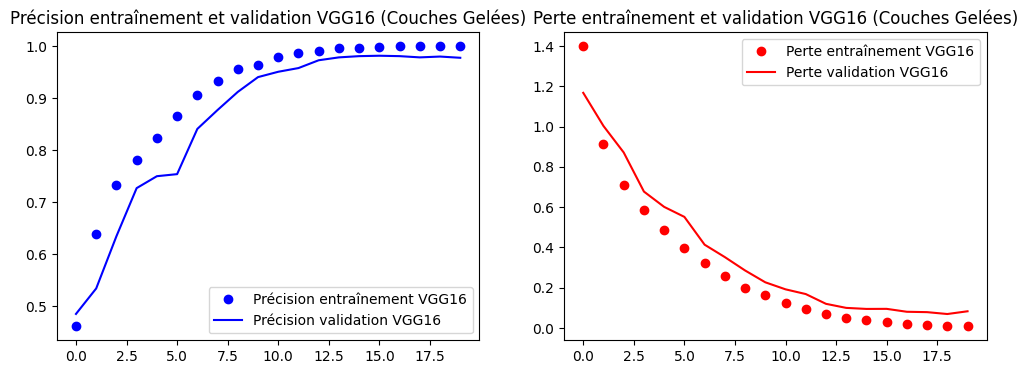

In [ ]:
acc_vgg = history_resnet.history['accuracy']
val_acc_vgg = history_resnet.history['val_accuracy']
loss_vgg = history_resnet.history['loss']
val_loss_vgg = history_resnet.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_vgg, 'bo', label='Précision entraînement VGG16')
plt.plot(epochs, val_acc_vgg, 'b', label='Précision validation VGG16')
plt.title('Précision entraînement et validation VGG16 (Couches Gelées)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vgg, 'ro', label='Perte entraînement VGG16')
plt.plot(epochs, val_loss_vgg, 'r', label='Perte validation VGG16')
plt.title('Perte entraînement et validation VGG16 (Couches Gelées)')
plt.legend()

plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step


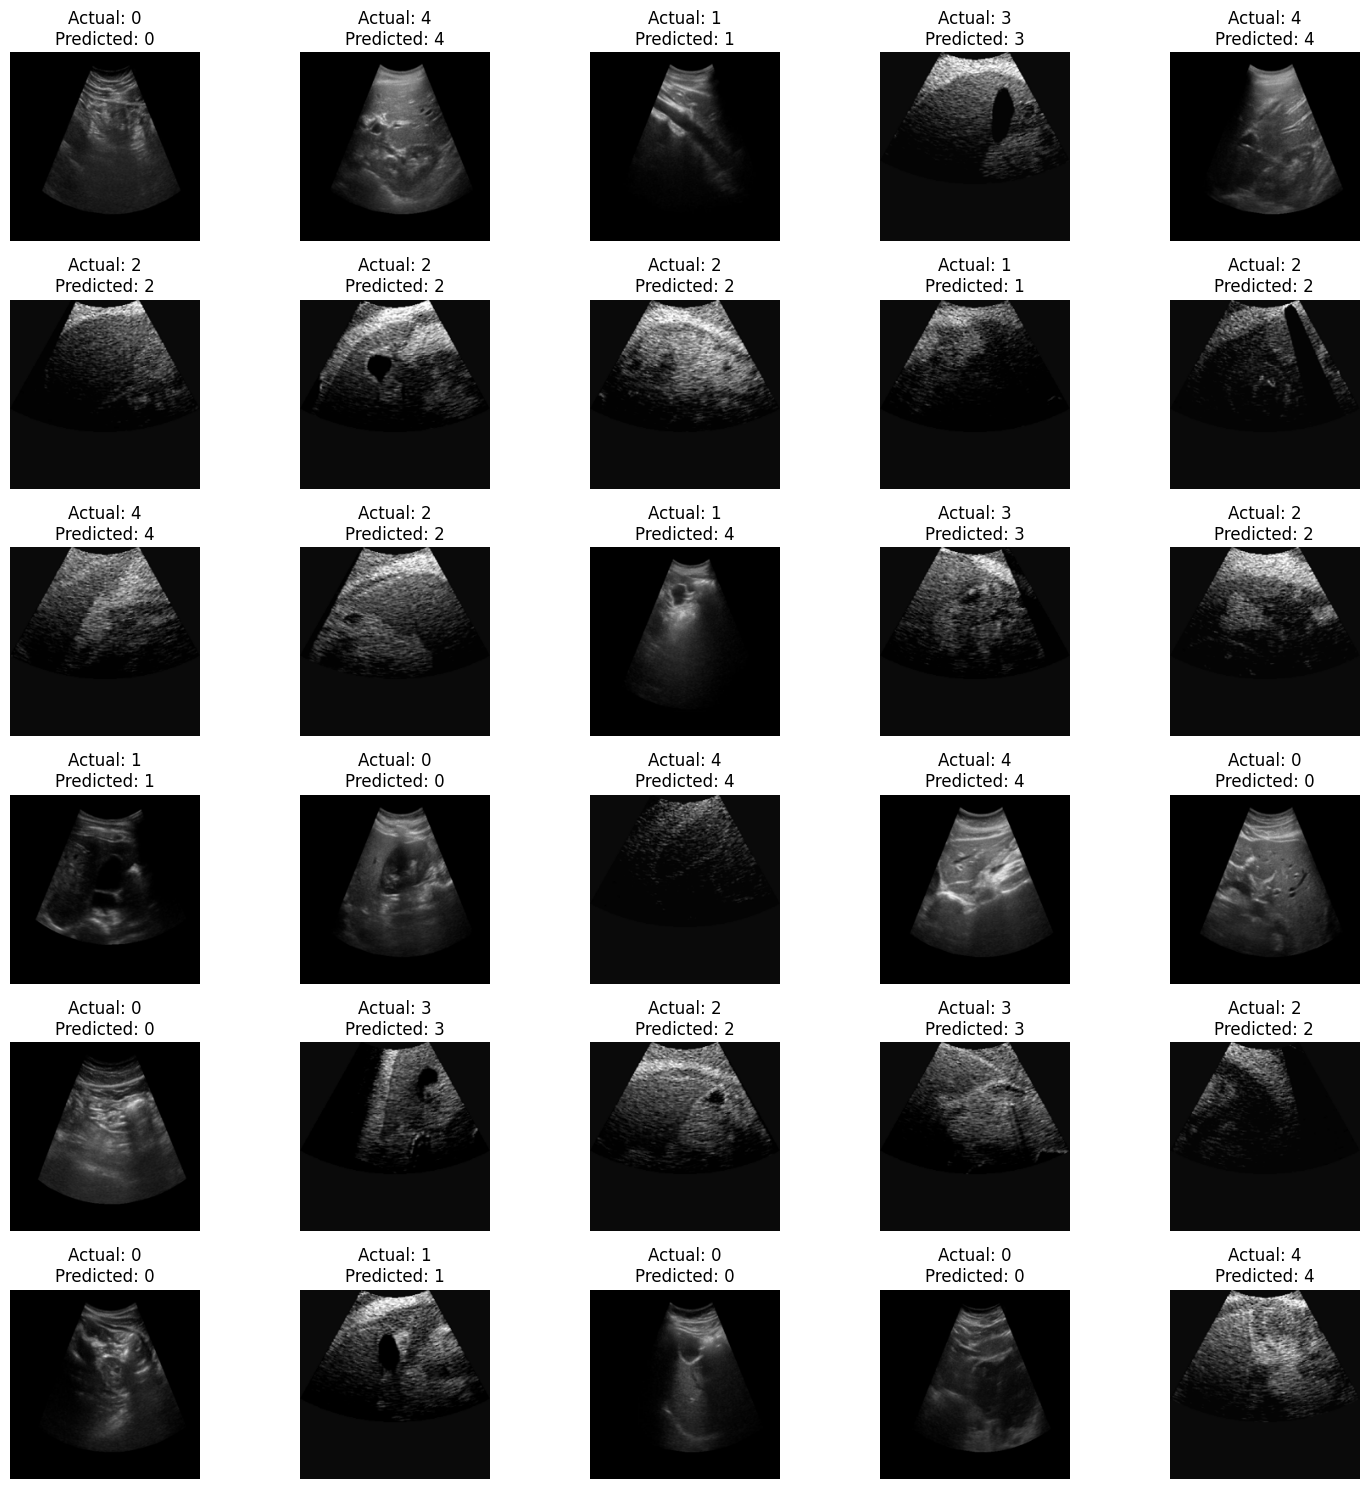

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the validation set
y_pred = model_resnet.predict(X_val)

# Get the predicted class labels (for sparse categorical crossentropy, we use argmax)
y_pred_labels = np.argmax(y_pred, axis=1)

# Randomly select 30 images and their corresponding labels
num_images = 30
random_indices = np.random.choice(X_val.shape[0], num_images, replace=False)

# Set up the plot
plt.figure(figsize=(15, 15))

# Loop over the selected random indices to plot the images
for i, idx in enumerate(random_indices):
    plt.subplot(6, 5, i+1)  # 6 rows, 5 columns
    img = X_val[idx].squeeze()  # Remove the channel dimension if it's there
    actual_label = y_val[idx]
    predicted_label = y_pred_labels[idx]

    # Plot the image
    plt.imshow(img, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Turn off axes

    # Set the title with the actual and predicted labels
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()